In [ ]:
# installing Hugging face libraries
!pip install -q -U watermark
!pip install -qq transformers

In [ ]:
# importing Libraries

import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
train_path = '/content/Emotion_Classify/train.txt'
val_path = '/content/Emotion_Classify/val.txt'
test_path = '/content/Emotion_Classify/test.txt'

In [ ]:
with open(train_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

train_data = [line.strip().split(';') for line in lines]
df_train = pd.DataFrame(train_data, columns=['comment', 'label'])
df_train = df_train[:len(df_train) // 2]



In [ ]:
df_train.head(5)

,comment,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
with open(val_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

val_data = [line.strip().split(';') for line in lines]
df_val = pd.DataFrame(val_data, columns=['comment', 'label'])

In [ ]:
with open(test_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

test_data = [line.strip().split(';') for line in lines]
df_test = pd.DataFrame(test_data, columns=['comment', 'label'])

In [ ]:
print(df_train['label'].value_counts())
print('===============')
print(df_val['label'].value_counts())
print('===============')
print(df_test['label'].value_counts())


label
joy         2693
sadness     2298
anger       1091
fear         935
love         661
surprise     322
Name: count, dtype: int64
label
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64
label
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64


label
joy         2693
sadness     2298
anger       1091
fear         935
love         661
surprise     322
Name: count, dtype: int64


<ipython-input-10-19800f4f529e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=df_train, palette=HAPPY_COLORS_PALETTE)
<ipython-input-10-19800f4f529e>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names)


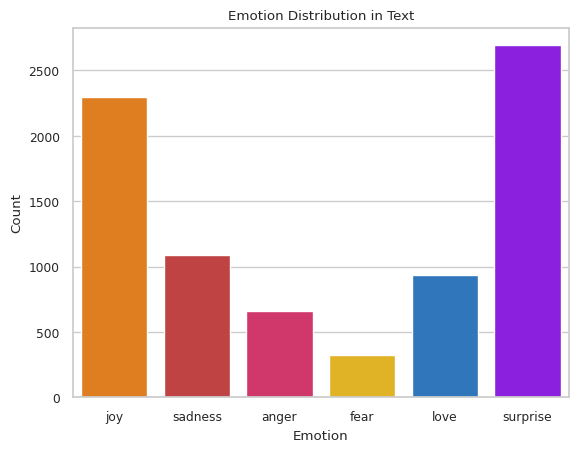

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print(df_train['label'].value_counts())

# Updated list of class names (new labels)
class_names = ['joy', 'sadness', 'anger', 'fear', 'love', 'surprise']

sns.set(style='whitegrid', palette='muted', font_scale=0.8)
HAPPY_COLORS_PALETTE = {"joy": "#8F00FF", "sadness": "#FF7D00", "anger": "#D32F2F",
                        "fear": "#1976D2", "love": "#E91E63", "surprise": "#FFC107"}
ax = sns.countplot(x='label', data=df_train, palette=HAPPY_COLORS_PALETTE)

plt.xlabel('Emotion')
plt.ylabel('Count')

# Ensure the x-tick labels match the order of 'class_names'
ax.set_xticklabels(class_names)

# Set the title of the plot
plt.title('Emotion Distribution in Text')

# Show the plot
plt.show()


In [ ]:
emotion_map = {'joy': 0,'sadness': 1,'anger': 2,'fear': 3,'love': 4,'surprise': 5}

df_train['label_numeric'] = df_train['label'].map(emotion_map)
df_val['label_numeric'] = df_val['label'].map(emotion_map)
df_test['label_numeric'] = df_test['label'].map(emotion_map)


# Check the first 10 rows to confirm the mapping
print(df_train.head(10))


                                             comment     label  label_numeric
0                            i didnt feel humiliated   sadness              1
1  i can go from feeling so hopeless to so damned...   sadness              1
2   im grabbing a minute to post i feel greedy wrong     anger              2
3  i am ever feeling nostalgic about the fireplac...      love              4
4                               i am feeling grouchy     anger              2
5  ive been feeling a little burdened lately wasn...   sadness              1
6  ive been taking or milligrams or times recomme...  surprise              5
7  i feel as confused about life as a teenager or...      fear              3
8  i have been with petronas for years i feel tha...       joy              0
9                                i feel romantic too      love              4


In [ ]:
print(df_train['label'].value_counts())

label
joy         2693
sadness     2298
anger       1091
fear         935
love         661
surprise     322
Name: count, dtype: int64


'Preprocessing and classification'

using df_reviews['Reviews'] is bert with sentiment labels will be preprocessing this using bert tokenizer

In [ ]:
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

# Tokenization

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


*tokenize()*: This method converts the raw text into tokens, using the WordPiece tokenization

*convert_tokens_to_ids()*: This method takes the tokens and converts them into corresponding integer IDs from the models vocabulary.

*encode()*: This method combines tokenization, adding special tokens, and converting tokens into token IDs in a single step. It returns a list of token IDs, including the **[CLS]** and **[SEP]** tokens.

 * 101: [CLS] token (start of sequence).
 * 102: [SEP] token (end of sequence).

*return_attention_mask=True*: Returns the attention mask, which is used to tell the model which tokens are real words and which are padding tokens

*decode()*: Converts token IDs back into the human-readable text form, reconstructing the original sentence (or something very close to it, depending on tokenization)

In the context of tokenization, *max_length* refers to the maximum number of tokens (words or subwords) that can be used as input for a model, such as BERT or other transformer-based models.









In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class EmotionDataset(Dataset):

  def __init__(self, comments, targets, tokenizer, max_len):
    self.comments = comments
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.comments)

  def __getitem__(self, item):
    comment = str(self.comments[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      comment,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
    )

    return {
      'comment_text': comment,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
def data_loader(df, tokenizer, max_len, batch_size, shuffle=True, num_workers=4, pin_memory=True):

    comments = df['comment'].tolist()
    targets = df['label_numeric'].tolist()

    # Initialize the dataset
    dataset = EmotionDataset(
        comments=comments,
        targets=targets,
        tokenizer=tokenizer,
        max_len=max_len
    )

    # Create and return the DataLoader
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

In [ ]:
print(df_train.shape, df_test.shape, df_val.shape)

(8000, 3) (2000, 3) (2000, 3)


In [ ]:
#
batch_size = 10
max_len= 256

train_data_loader = data_loader(df_train, tokenizer, max_len, batch_size)
val_data_loader =   data_loader(df_val, tokenizer,   max_len, batch_size)
test_data_loader =  data_loader(df_test, tokenizer,  max_len, batch_size)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)


torch.Size([10, 256])
torch.Size([10, 256])
torch.Size([10])


In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
      outputs = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
      output = self.drop(outputs.pooler_output)
      return self.out(output)


In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length
model(input_ids, attention_mask)


torch.Size([10, 256])
torch.Size([10, 256])


tensor([[-2.9203e-02, -4.5349e-01, -5.5598e-02,  1.9916e-01, -4.2142e-01,
         -2.5403e-01],
        [ 1.4309e-02,  2.0710e-01, -2.3153e-01,  3.6309e-02, -6.7637e-02,
         -2.6750e-01],
        [ 2.5710e-01, -2.1710e-01, -1.8043e-01, -2.4999e-01, -5.0147e-01,
          3.7503e-02],
        [-5.1691e-02, -3.5803e-02, -1.4259e-01,  5.1360e-01, -3.6479e-01,
          3.2890e-01],
        [-5.4964e-01, -1.8357e-01, -3.9047e-01,  3.0886e-01, -6.7792e-01,
          4.2956e-01],
        [ 3.7512e-01,  2.8539e-01,  1.0107e-01, -3.6027e-01, -6.6514e-01,
          5.6906e-01],
        [-3.9670e-02, -3.2405e-02, -2.1807e-01,  3.7163e-01, -1.6810e-01,
         -2.8989e-01],
        [-3.5690e-01,  1.4493e-01, -4.1464e-01,  2.1708e-02, -6.3791e-03,
         -3.7193e-02],
        [-3.4853e-01,  6.7484e-01, -4.2758e-01,  3.0095e-01, -2.1880e-01,
         -3.5481e-01],
        [-2.8417e-01,  3.3072e-01, -3.2771e-01, -2.9022e-04, -5.5663e-01,
          2.6489e-01]], device='cuda:0', grad_fn=<Add

In [ ]:
def compute_metrics(outputs, targets, loss_fn):
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions = torch.sum(preds == targets).item()
    return loss.item(), correct_predictions

In [ ]:
from collections import defaultdict
import torch
import torch.nn as nn
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm  # Import tqdm for progress bars

# Hyperparameters
EPOCHS = 5
LEARNING_RATE = 2e-5
BATCH_SIZE = 50  # You can adjust this based on your memory limitations

# Define the device (ensure it's either GPU or CPU based on availability)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optimizer setup with weight decay for regularization
optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=0.01,  # Regularization term
    correct_bias=False
)

# Calculate total steps for scheduler
total_steps = len(train_data_loader) * EPOCHS

# Learning rate scheduler setup with warmup
num_warmup_steps = int(0.1 * total_steps)  # Use 10% of total steps for warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_steps
)

# Loss function (CrossEntropyLoss for classification)
loss_fn = nn.CrossEntropyLoss().to(device)

# Train and Eval Functions
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model.train()
    losses = []
    correct_predictions = 0
    progress_bar = tqdm(data_loader, desc="Training", total=len(data_loader), leave=False)

    for d in progress_bar:
        input_ids = d["input_ids"].to(device)  # Tensor with shape [batch_size, max_len]
        attention_mask = d["attention_mask"].to(device)  # Same shape [batch_size, max_len]
        targets = d["targets"].to(device)  # Tensor with shape [batch_size]

        optimizer.zero_grad()

        # Forward pass through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Convert model output to predictions
        _, preds = torch.max(outputs, dim=1)

        # Calculate loss
        loss = loss_fn(outputs, targets)

        # Backward pass
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        # Track correct predictions and losses
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Update progress bar
        progress_bar.set_postfix(loss=loss.item(), accuracy=(correct_predictions.double() / len(d)).item())

    # Calculate and return accuracy and loss for the epoch
    train_acc = correct_predictions.double() / n_examples
    train_loss = sum(losses) / len(losses)

    return train_acc, train_loss


def eval_model(model, data_loader, loss_fn, device, n_examples):
    model.eval()  # Set model to evaluation mode
    losses = []
    correct_predictions = 0
    progress_bar = tqdm(data_loader, desc="Validation", total=len(data_loader), leave=False)

    with torch.no_grad():
        for d in progress_bar:
            input_ids = d["input_ids"].to(device)  # This will have shape [batch_size, max_len]
            attention_mask = d["attention_mask"].to(device)  # Same shape [batch_size, max_len]
            targets = d["targets"].to(device)  # Labels for classification

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            # Update progress bar with loss and accuracy
            progress_bar.set_postfix(loss=loss.item(), accuracy=(correct_predictions.double() / len(d)).item())

    # Calculate average accuracy and loss for the validation set
    val_acc = correct_predictions.double() / n_examples
    val_loss = sum(losses) / len(losses)

    return val_acc, val_loss

# Example Training Loop with train_epoch and eval_model functions
history = defaultdict(list)  # This is where defaultdict is used
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    # Training phase
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.2f}%')

    # Validation phase
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val loss: {val_loss:.4f} | Val accuracy: {val_acc:.2f}%')
    print()

    # Log history
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Save the model if validation accuracy improves
    if val_acc > best_accuracy:
        print(f'Validation accuracy improved from {best_accuracy:.2f}% to {val_acc:.2f}%. Saving model...')
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


Epoch 1/5
----------


Train loss: 0.7365 | Train accuracy: 0.74%


Val loss: 0.2987 | Val accuracy: 0.92%

Validation accuracy improved from 0.00% to 0.92%. Saving model...
Epoch 2/5
----------


Train loss: 0.2091 | Train accuracy: 0.94%


Val loss: 0.2360 | Val accuracy: 0.93%

Validation accuracy improved from 0.92% to 0.93%. Saving model...
Epoch 3/5
----------


Train loss: 0.1266 | Train accuracy: 0.96%


Val loss: 0.2114 | Val accuracy: 0.94%

Validation accuracy improved from 0.93% to 0.94%. Saving model...
Epoch 4/5
----------


Train loss: 0.0757 | Train accuracy: 0.97%


Val loss: 0.2498 | Val accuracy: 0.93%

Epoch 5/5
----------


Train loss: 0.0375 | Train accuracy: 0.99%


Val loss: 0.2694 | Val accuracy: 0.94%



In [ ]:

train_acc = [x.cpu().numpy() for x in history['train_acc']]
val_acc =   [x.cpu().numpy() for x in history['val_acc']]  # These are already in a list, so no need to move to CPU
train_loss = history['train_loss']  # These are already in a list, so no need to move to CPU
val_loss = history['val_loss']  # These are already in a list, so no need to move to CPU

# Epochs (you can use the length of any of the history lists)
epochs = range(1, len(train_acc) + 1)

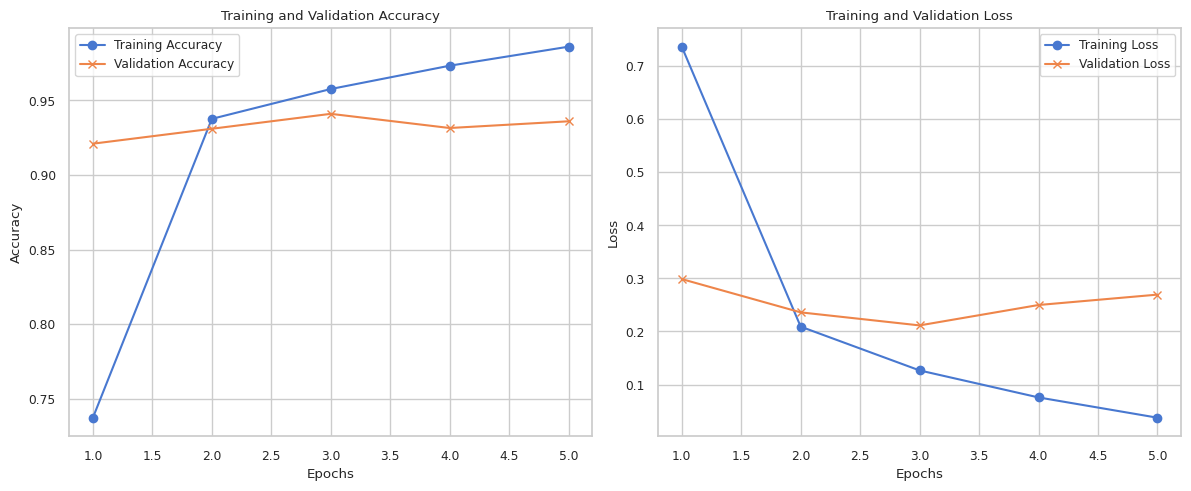

In [ ]:
plt.figure(figsize=(12, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()


0.917

In [ ]:
# Switch model to evaluation mode
model = model.eval()

# Initialize lists to store outputs
review_texts = []
predictions = []
prediction_probs = []
real_values = []

# Disable gradient calculation for inference
with torch.no_grad():
    # Loop through the test data loader
    for d in test_data_loader:
        # Extract the batch data
        texts = d["comment_text"]
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        # Forward pass through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Get the predicted class labels
        _, preds = torch.max(outputs, dim=1)

        # Get the probabilities (softmax)
        probs = F.softmax(outputs, dim=1)

        # Append results to lists
        review_texts.extend(texts)
        predictions.extend(preds)
        prediction_probs.extend(probs)
        real_values.extend(targets)

# Convert the predictions and probabilities to CPU and stack them
y_pred = torch.stack(predictions).cpu()
y_pred_probs = torch.stack(prediction_probs).cpu()
y_test = torch.stack(real_values).cpu()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

         joy       0.95      0.94      0.94       695
     sadness       0.96      0.95      0.95       581
       anger       0.91      0.91      0.91       275
        fear       0.88      0.87      0.88       224
        love       0.81      0.84      0.82       159
    surprise       0.69      0.79      0.74        66

    accuracy                           0.92      2000
   macro avg       0.87      0.88      0.87      2000
weighted avg       0.92      0.92      0.92      2000

